In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.1163
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

In [41]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/cfgs_CGWokringCPU'
with open(path,'r') as f:
    cfgs=f.read().splitlines()

def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

def symmetrizeP(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return (dat+dat_bw)/2

path1='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15_multiMethod_Nsrc=50/data_merge/NpiScatteringWilson.h5'
path2='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/NpiScatteringWilson.h5'

np.set_printoptions(precision=1,suppress=True)
with h5py.File(path1) as f1, h5py.File(path2) as f2:
    cfgs_all=[cfg.decode() for cfg in f1['cfgs'][:]]
    cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs]
    
    cp=np.real(yu.jackknife(symmetrizeP(f1['data/P'][:,:,0])))
    cps=np.real(yu.jackknife(symmetrizeP(f1['data/P'][cfgs_map,:,0])))
    
    tau=1
    def C2pt2meff(C2pt,totalT):
        tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
        t=C2pt # dim=time
        t=(np.roll(t,-tau,axis=0))/(t)
        t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
        return t
    func=lambda c2pt:C2pt2meff(c2pt,48)
    mp=yu.jackmap(func,cp)
    mps=yu.jackmap(func,cps)
    
    c1=np.real(yu.jackknife(symmetrize(f1['data/N'][:,:,16])))
    c2=np.real(yu.jackknife(symmetrize(f2['data/N'][:,:,16])))
    
    c1s=np.real(yu.jackknife(symmetrize(f1['data/N'][cfgs_map,:,16])))
    c2s=np.real(yu.jackknife(symmetrize(f2['data/N'][cfgs_map,:,16])))
    
    mean1,err1=yu.jackme(c1)
    mean2,err2=yu.jackme(c2)
    print((err1/err2)**2)
    
    # mean1,err1=yu.jackme(c1s)
    # mean2,err2=yu.jackme(c2s)
    # print((err1/err2)**2)
    
    func=lambda c:np.log(c/np.roll(c,-1))
    m1=yu.jackmap(func,c1)
    m2=yu.jackmap(func,c2)
    
    m1s=yu.jackmap(func,c1s)
    m2s=yu.jackmap(func,c2s)
    
    mean1,err1=yu.jackme(m1)
    mean2,err2=yu.jackme(m2)
    print((err1/err2)**2)

[13.   4.4  4.6  4.5  4.6  3.9  3.3  3.5  4.   4.6  4.8  5.1  6.9  7.4
  5.   3.8  4.3  4.6  4.9  3.2  3.   5.3  9.   8.  17.1 13.4  4.6  2.9
  1.6  3.5  7.5 24.2 23.9 10.1  6.6  4.3  4.5  3.   3.7  5.1  7.7  9.6
  5.6  6.   7.   6.5  6.1  5. ]
[  nan   5.9   5.4   7.    4.7   6.2   5.5   6.3   8.5   9.5   9.    7.2
   7.7   4.8   8.2  17.   25.1  54.  428.3 418.8   nan   nan   nan   0.2
   nan   nan   nan   nan   nan   nan   nan   nan   0.1   0.1   nan   0.
   1.    2.1   1.6   2.6   3.5   9.9   4.8   5.2   6.3   6.2   8.2   nan]


<ErrorbarContainer object of 3 artists>

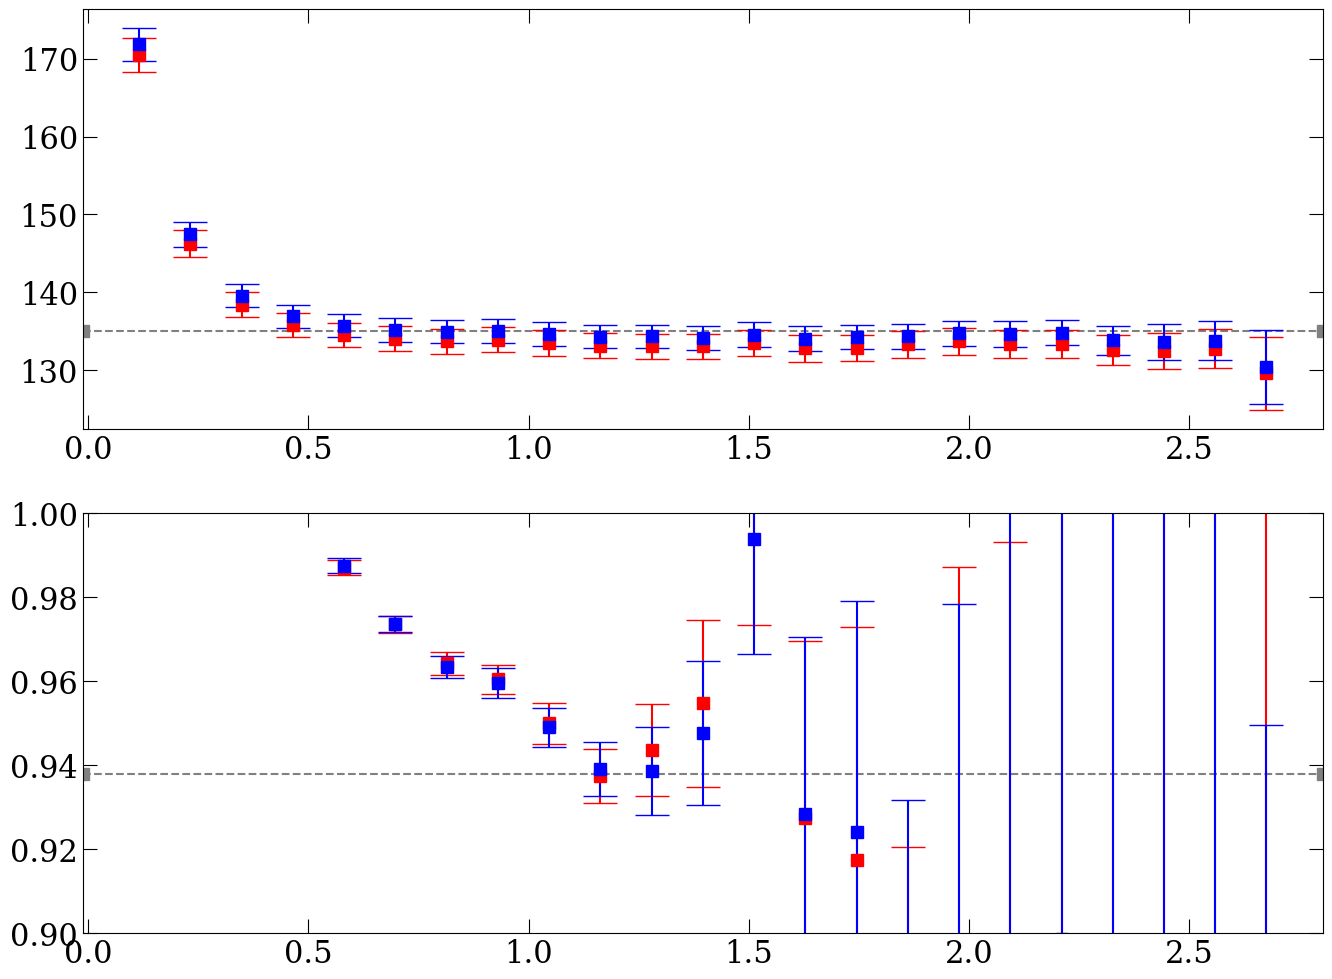

In [56]:
fig, axs = yu.getFigAxs(2,1,Lrow=6,Lcol=16)

ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=24
# ax.set_ylim([0.9,1.5])
ax.axhline(135,color='grey',ls='--')

mean,err=yu.jackme(mp)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(mps)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24
ax.set_ylim([0.9,1.0])
ax.axhline(0.938,color='grey',ls='--')

mean,err=yu.jackme(m2)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(m2s)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

In [15]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_post/'
cfgs=os.listdir(path)
data=[]
for cfg in cfgs:
    file=f'{path}{cfg}/N.h5_0mom'
    with h5py.File(file) as f:
        print(f['data'].keys())
        break

<KeysViewHDF5 ['sx00sy03sz40st16', 'sx00sy26sz39st41', 'sx00sy38sz01st35', 'sx00sy40sz33st00', 'sx00sy44sz17st03', 'sx00sy46sz03st24', 'sx00sy47sz02st21', 'sx00sy47sz29st44', 'sx01sy01sz13st02', 'sx01sy15sz43st41', 'sx01sy32sz33st43', 'sx02sy06sz04st36', 'sx02sy10sz39st38', 'sx02sy12sz34st42', 'sx02sy13sz22st44', 'sx02sy15sz10st07', 'sx02sy21sz03st36', 'sx02sy36sz05st07', 'sx02sy39sz35st34', 'sx03sy02sz38st32', 'sx03sy08sz14st24', 'sx03sy08sz16st04', 'sx03sy18sz09st14', 'sx03sy20sz42st12', 'sx03sy23sz24st40', 'sx03sy26sz40st22', 'sx03sy31sz29st05', 'sx03sy40sz37st24', 'sx03sy47sz34st12', 'sx04sy04sz41st34', 'sx04sy14sz19st23', 'sx04sy16sz09st31', 'sx04sy24sz02st39', 'sx04sy29sz05st22', 'sx04sy32sz38st24', 'sx04sy34sz29st02', 'sx04sy41sz29st08', 'sx04sy42sz31st15', 'sx04sy45sz09st25', 'sx04sy47sz02st03', 'sx05sy07sz21st40', 'sx05sy08sz44st34', 'sx05sy15sz19st03', 'sx05sy23sz17st37', 'sx05sy24sz37st46', 'sx05sy25sz03st17', 'sx05sy35sz46st29', 'sx05sy45sz29st03', 'sx06sy00sz09st47', 'sx06

In [ ]:
path1='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15_multiMethod_Nsrc=50/data_merge/NpiScatteringWilson.h5'
path2='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/NpiScatteringWilson.h5'

with h5py.File(path1) as f1, h5py.File(path2) as f2:
    t1=f1['data/N'][:,:,16,0]
    t2=f2['data/N'][:,:,16,0]
    
    mean1,err1=yu.jackme(t1)
    mean2,err2=yu.jackme(t2)
    print((err1/err2)**2)